In [1]:
def subsample_labels(df, labels):
    return df.loc[df['label'].isin(labels)]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


df = pd.read_csv('results/feature_vector.csv', index_col=0)
df = df[df['group'] == 'hearing'] #'hearing', 'C', D
label_names = ['angry','happy', 'neutral', 'sad'] #['neutral', 'angry']
df = subsample_labels(df, label_names)

labels = df['label']
# labels = df['group']
group = df['group']
df.drop(['label', 'group'], axis=1, inplace=True)
len(labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, random_state=0, test_size=0.3, stratify=labels)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

clf = RandomForestClassifier(criterion='entropy')
cv_scores = cross_val_score(clf, df, labels, cv=10)

print(cv_scores)
print(np.mean(cv_scores))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

clf = RandomForestClassifier(criterion='entropy')
clf.fit(df, labels)
feature_imp = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)

def plot_importance(clf):
    clf.fit(df, labels)
    feature_imp_ = pd.Series(clf.feature_importances_,index=df.columns.tolist()).sort_values(ascending=False)
    feature_imp_ = feature_imp_[0:5]


    sns.barplot(x=feature_imp_, y=feature_imp_.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")
    # plt.title("Hearing - Vs. None hearing")
    plt.legend()
    plt.show()

plot_importance(clf)
len(feature_imp)

In [ ]:
xtrain = X_train[feature_imp[0:92].index.to_list()]
xtest = X_test[feature_imp[0:92].index.to_list()]


clf = RandomForestClassifier(criterion='entropy', max_depth=11)
clf.fit(xtrain, y_train)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))
f1_ = f1_score(y_test, y_pred, average='macro')
prec = precision_score(y_test, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
plot_importance(clf)


In [ ]:
# overfit 
clf = RandomForestClassifier(criterion='entropy', max_depth=3)
clf.fit(df, labels)

y_pred = clf.predict(df)
print(classification_report(labels, y_pred, labels=clf.classes_))
f1_ = f1_score(labels, y_pred, average='macro')
prec = precision_score(labels, y_pred, average='macro')
print(f'f1: {f1_}')
print(f'prec: {prec}')

cm = confusion_matrix(labels, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
plot_importance(clf)

In [ ]:
# score per feature - over train - test split
# from tqdm import tqdm
# f1s = []
# prec = []
# for num_features in tqdm(range(5, 121)):
    
#     xtrain = subsample_features(X_train, feature_imp[0:num_features])
#     xtest = subsample_features(X_test, feature_imp[0:num_features])
#     clf = RandomForestClassifier(criterion='entropy', max_depth=5)
#     clf.fit(xtrain, y_train)
#     y_pred = clf.predict(xtest)
#     f1s.append(f1_score(y_test, y_pred, average='macro'))
#     prec.append(precision_score(y_test, y_pred, average='macro'))

# plt.plot(list(range(5,121)), f1s, label='F1')
# plt.plot(list(range(5,121)), prec, label='precision')
# plt.xlabel('Num of features')
# plt.ylabel('Score')
# plt.title('Evaluation over #features')
# plt.legend()


# print(f'features: {np.argmax(prec)} prec: {prec[np.argmax(prec)]} ')
# print(f'features: {np.argmax(f1s)} f1: {f1s[np.argmax(f1s)]} ')

In [ ]:
# cv score average per feature on the x -axis
from tqdm import tqdm
cv_aver = []
fe_range = np.linspace(5, 121, 25).astype(int)
for num_features in tqdm(fe_range):
    df_ = df[feature_imp[0:num_features].index.to_list()]
    clf = RandomForestClassifier(criterion='entropy', max_depth=11)
    cv_scores = cross_val_score(clf, df_, labels, cv=10)
    cv_aver.append(np.mean(cv_scores))

plt.plot(fe_range, cv_aver, label='CV')
plt.xlabel('Num of features')
plt.ylabel('Score')
plt.title('CV Score - average of 10 fold')
plt.legend()


max_idx = np.argmax(cv_aver)
features_max = fe_range[max_idx]
print(f'features: {features_max} cv: {cv_aver[max_idx]} ')

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
clf.fit(df, y)


fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf, filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
# clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
# clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf.estimators_[0], filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')


[Text(0.7511160714285714, 0.95, 'AU12_mean <= 1.153\nentropy = 1.936\nsamples = 160\nvalue = [39, 61, 67, 93]\nclass = sad'),
 Text(0.5558035714285714, 0.85, 'AU15_e0_length <= 1.5\nentropy = 1.872\nsamples = 135\nvalue = [38, 32, 57, 93]\nclass = sad'),
 Text(0.36160714285714285, 0.75, 'AU07_e2_length <= 7.25\nentropy = 1.799\nsamples = 96\nvalue = [14, 29, 46, 69]\nclass = sad'),
 Text(0.26339285714285715, 0.65, 'AU02_e1_intensity <= 0.2\nentropy = 1.693\nsamples = 73\nvalue = [8, 15, 45, 51]\nclass = sad'),
 Text(0.1875, 0.55, 'AU15_mean <= 0.09\nentropy = 1.727\nsamples = 65\nvalue = [8, 14, 45, 37]\nclass = neutral'),
 Text(0.08928571428571429, 0.45, 'AU15_mean <= 0.067\nentropy = 1.143\nsamples = 22\nvalue = [1, 0, 19, 20]\nclass = sad'),
 Text(0.05357142857142857, 0.35, 'AU02_std <= 0.178\nentropy = 0.868\nsamples = 9\nvalue = [1, 0, 13, 2]\nclass = neutral'),
 Text(0.03571428571428571, 0.25, 'AU05_e2_length <= 6.25\nentropy = 0.371\nsamples = 8\nvalue = [1, 0, 13, 0]\nclass = n

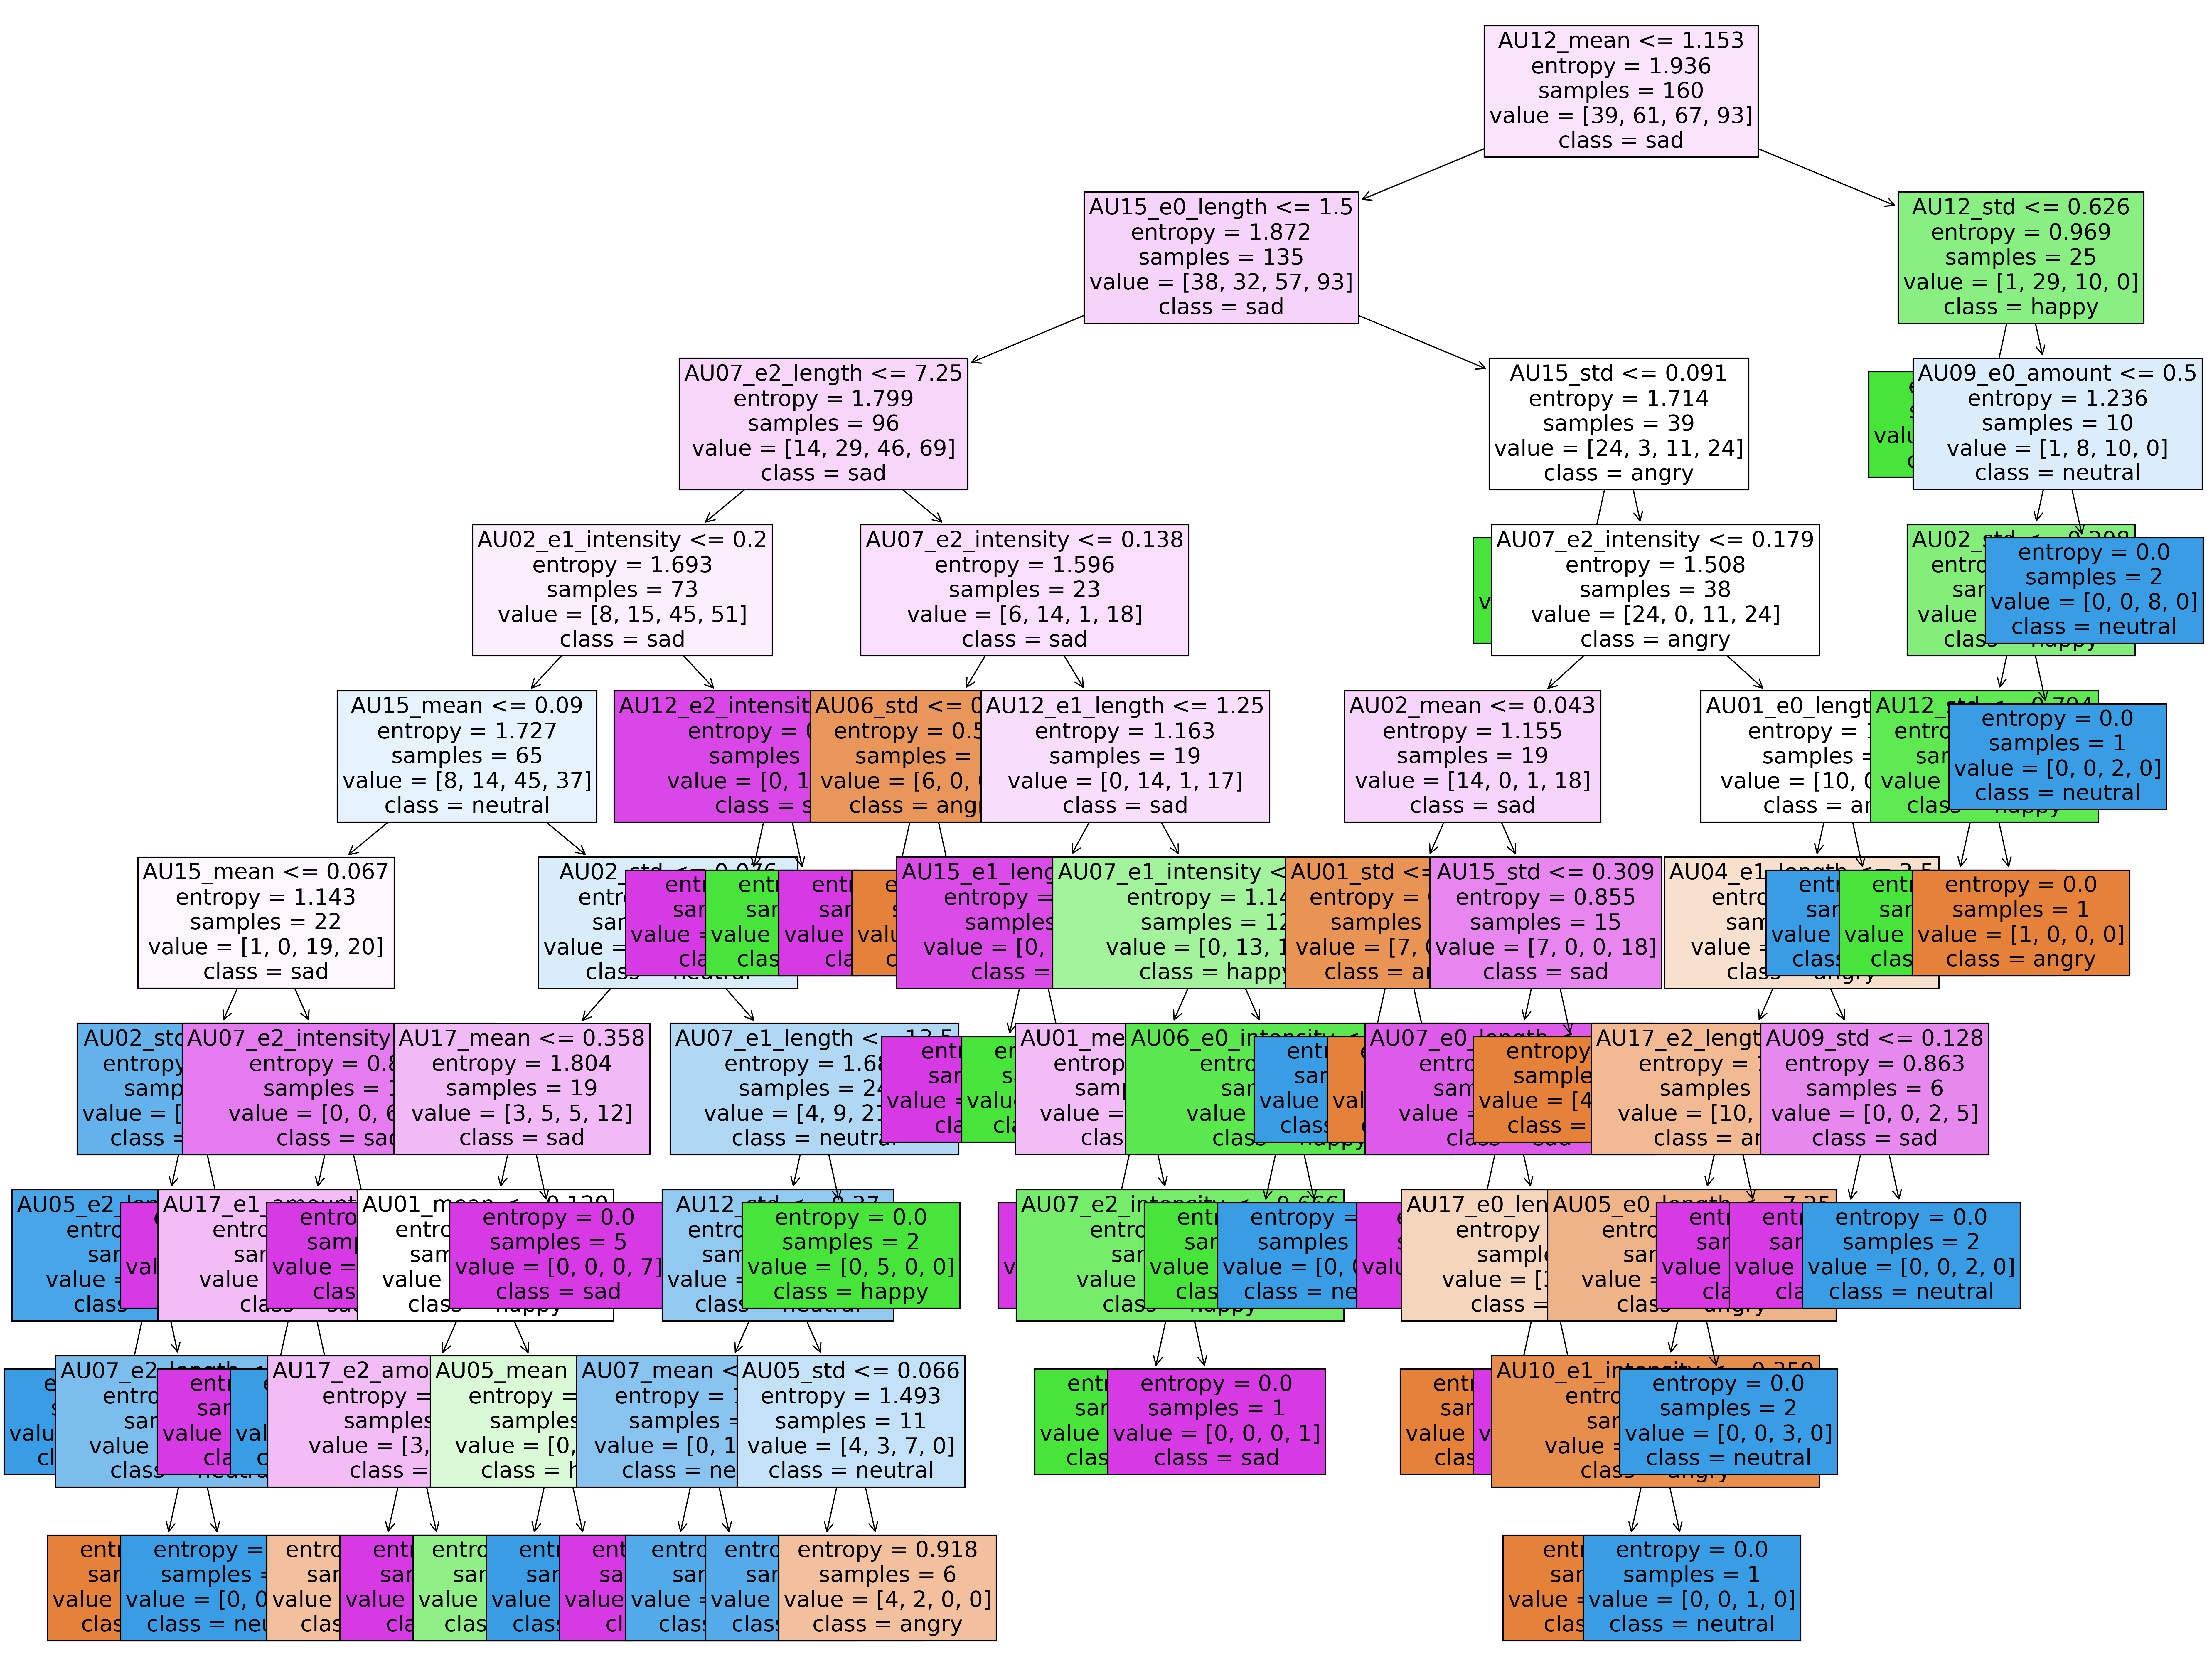

In [36]:
import matplotlib.pyplot as plt
from sklearn import tree
# clf = DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=3)
# clf.fit(df, labels)

fig = plt.figure(figsize=(30,25), dpi=300)
tree.plot_tree(clf.estimators_[0], filled=True, fontsize = 18, feature_names = df.columns.tolist(), class_names=label_names)
# plt.savefig('out.jpeg')
